In [35]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

# visualization
import pydotplus
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import FactorAnalysis

#preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


import warnings
warnings.filterwarnings('ignore')


# I. Acquire data

The Python Pandas packages helps us work with our datasets. We start by acquiring the training and testing datasets into Pandas DataFrames. We also combine these datasets to run certain operations on both datasets together.

In [36]:
train_data = pd.read_csv('../../dataset/titanic/train.csv')
test_data = pd.read_csv('../../dataset/titanic/test.csv')

# II. Exploratory Data Analysis

# III. Let's build our first model : baseline

# IV. Let's build improve our model



## a. Preprocessing

In [37]:
train_df = train_data.copy()
test_df = test_data.copy()
y = train_data['Survived']

full_data = [train_df, test_df]


for dataset in full_data:
    # Gives the length of the name
    dataset['Name_length'] = dataset['Name'].apply(len)
    # Feature that tells whether a passenger had a cabin on the Titanic
    dataset['Has_Cabin'] = dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
    # Create new feature FamilySize as a combination of SibSp and Parch
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    # Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    # Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('W')
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2,'W':3} ).astype(int)
    # Remove all NULLS in the Fare column and create a new feature CategoricalFare
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
    
    # Gui et parenthese
    dataset['parenthese'] = dataset['Name'].apply(lambda x : '(' in(x)  ).astype(int)
    dataset['guill'] = dataset['Name'].apply(lambda x : '"' in(x)  ).astype(int)
    #Random varaible to controle the feature importance
    dataset['Random'] = np.random.randn(dataset.shape[0])
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    # Create a new feature Title, containing the titles of passenger names
    dataset['Title'] = dataset['Name'].apply(lambda x : x.split(',')[1].split('.')[0].strip())
    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady','the Countess', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
    # Create a New feature CategoricalAge
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    dataset['Ticket'] = dataset['Ticket'].apply(lambda x : x.isdigit()).astype(int)
    #Cabin lettre
    dataset['Cabin_lettre'] = dataset['Cabin'].fillna('X')
    dataset['Cabin_lettre'] = dataset['Cabin_lettre'].apply( lambda x : x.split()[0][0] )


#Don't use the test statistics in train
train_df['CategoricalFare'] = pd.qcut(train_df['Fare'], 4)
train_df['CategoricalAge'] = pd.cut(train_df['Age'], 5)#!!!may only for train

#Binning
for dataset in full_data:
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;
    
# Feature selection
train_df = train_df.drop(['PassengerId', 'Name','Cabin', 'SibSp','Parch','CategoricalAge', 'CategoricalFare','Survived'], axis = 1)
test_df  = test_df.drop(['PassengerId', 'Name', 'Cabin','SibSp', 'Parch',], axis = 1)


In [38]:
#categories1 = [['Sex']]
#for cat in categories1:
#    lb = OrdinalEncoder()
#    lb.fit(X[cat])
#    X[cat] = lb.transform(X[cat])
#    X_test[cat] = lb.transform(X_test[cat])

#For difference between get_dummies and OneHotEncoder
#https://stackoverflow.com/questions/36631163/pandas-get-dummies-vs-sklearns-onehotencoder-what-are-the-pros-and-cons
#One Hot encoding
#categories2 = ['Embarked']
#print(pd.get_dummies(X, columns=categories2))


categories = ['Cabin_lettre']                      
encoder = OneHotEncoder(categories='auto')
encoder.fit(train_df[categories])    # Assume for simplicity all features are categorical.

# Apply the encoder for train
feature_arr = encoder.transform(train_df[categories]).toarray()
features_enc = pd.DataFrame(data=feature_arr, columns=np.concatenate(encoder.categories_, axis=None))
train_df = train_df.join(features_enc,lsuffix='_caller', rsuffix='_other')


# Apply the encoder for test
feature_arr = encoder.transform(test_df[categories]).toarray()
features_enc = pd.DataFrame(data=feature_arr, columns=encoder.categories_)
test_df = test_df.join(features_enc,lsuffix='_caller', rsuffix='_other')


In [39]:
train_df

,Pclass,Sex,Age,Ticket,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,...,Cabin_lettre,A,B,C,D,E,F,G,T,X
0,3,1,1,0,0,0,23,0,2,0,...,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,2,0,3,1,51,1,2,0,...,C,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,1,0,1,0,22,0,1,1,...,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,2,1,3,0,44,1,2,0,...,C,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1,2,1,1,0,24,0,1,1,...,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,1,1,1,0,21,0,1,1,...,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,1,0,1,1,2,0,28,1,1,1,...,B,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,3,0,0,0,2,0,40,0,4,0,...,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,1,1,1,1,2,1,21,1,1,1,...,C,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
#features_enc
mask_numerical = (train_df.dtypes!='O').reset_index()
new_features = mask_numerical[mask_numerical[0]==True]['index'].values
new_features


array(['Pclass', 'Sex', 'Age', 'Ticket', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'parenthese',
       'guill', 'Random', 'Title', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T',
       'X'], dtype=object)

In [41]:
mask_numerical

,index,0
0,Pclass,True
1,Sex,True
2,Age,True
3,Ticket,True
4,Fare,True
5,Embarked,True
6,Name_length,True
7,Has_Cabin,True
8,FamilySize,True
9,IsAlone,True


In [42]:
plt.figure(figsize=(12,12))
_ = sns.heatmap(train_df.corr())

## b. Recursive Feature Elimination 

**Doc links:**
- https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
- https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/
- https://www.kaggle.com/reisel/how-to-handle-correlated-features
- https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

In [43]:
#Baseline

def build_model(features):

    X = train_df[features]
    sub_test = test_df[features]

    pca = PCA(n_components=6)
    pca.fit(X)
    X = pca.transform(X)
    sub_test = pca.transform(sub_test)

    cv = StratifiedKFold(n_splits=5,random_state=10,shuffle=True)

    results_df_test = pd.DataFrame()
    results_df_train = pd.DataFrame(data=np.zeros((5,2)),columns=['Train_error', 'Test_error'])

    fold = 0
    my_model = None
    
    for train_index, test_index in cv.split(X, y):

        X_train = X[train_index]
        y_train = y[train_index]

        X_test = X[test_index]
        y_test = y[test_index]

        #my_model = DecisionTreeClassifier(max_depth=7, min_samples_leaf=2)
        my_model = RandomForestClassifier(criterion='entropy', max_depth=5,n_estimators=160, n_jobs=-1)
        #my_model =  SGDClassifier()
        #my_model = ExtraTreesClassifier()
        
        my_model.fit( X_train,  y_train)

        pred_sub   = my_model.predict_proba(sub_test)[:,1]
        results_df_test['fold_'+str(fold)] = pred_sub

        pred_train = my_model.predict(X_train)
        pred_test = my_model.predict(X_test)

        score = 1 - accuracy_score(y_train,pred_train)
        results_df_train.loc[fold,'Train_error'] = round(score*100,2)

        score = 1 - accuracy_score(y_test,pred_test)    
        results_df_train.loc[fold,'Test_error'] = round(score*100,2)
        

        fold +=1
    
    return (results_df_test, results_df_train, my_model)

In [44]:
features = ['Sex', 'FamilySize', 'Embarked', 'Title', 'E', 'F']
features = ['Age',
 'B',
 'C',
 'FamilySize',
 'IsAlone',
 'Name_length',
 'Pclass',
 'Sex',
 'Ticket',
 'parenthese']
#features = ['Age','C','FamilySize','Fare','Has_Cabin','Name_length','Pclass']

features = new_features

#RF : features = ['Age', 'Has_Cabin', 'FamilySize', 'Title', 'B', 'E']
#ET : features = ['Has_Cabin', 'FamilySize', 'Title', 'A', 'E', 'F']
#features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'guill']

features = ['Pclass', 'Embarked', 'Has_Cabin', 'FamilySize', 'guill', 'Title']

results_df_test, results_df_train, my_model = build_model(features)
print(results_df_train.mean())
a = pd.DataFrame()
a['Name'] = features
a['Importance'] = my_model.feature_importances_
a.sort_values(by="Importance",ascending=False)


NameError: name 'PCA' is not defined

In [62]:
#https://towardsdatascience.com/feature-selection-using-wrapper-methods-in-python-f0d352b346f
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf = RandomForestClassifier(criterion='entropy', max_depth=5,n_estimators=160, n_jobs=-1)
dt= DecisionTreeClassifier(max_depth=7, min_samples_leaf=2)
sgb = SGDClassifier()
svc = SVC(kernel="linear")
et = ExtraTreesClassifier()


X = train_df[new_features]
    
# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=10,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5,n_jobs=-1)

# Perform SFFS
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:   13.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:   13.5s finished

[2022-01-28 12:41:34] Features: 1/10 -- score: 0.7901136149645345[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:   11.8s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   12.2s finished

[2022-01-28 12:41:46] Features: 2/10 -- score: 0.8192706044818279[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:   11.6s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   12.0s finished

[2022-01-28 12:41:58] Features: 3/10 -- score: 0.8271671583704727[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20

In [60]:
#('Fare', 'Has_Cabin', 'FamilySize', 'Title', 'E')
# ('Pclass', 'Sex', 'Ticket', 'E', 'X')
# 
sfs1.k_feature_names_

('Pclass',
 'Sex',
 'Ticket',
 'Embarked',
 'Name_length',
 'FamilySize',
 'IsAlone',
 'Title',
 'G',
 'T')

In [52]:
# https://scikit-learn.org/stable/modules/feature_selection.html?highlight=feature%20elimination
    
from sklearn.feature_selection import RFECV
svc = SVC(kernel="linear")
#rfe = RFECV(estimator= DecisionTreeClassifier(max_depth= 9, min_samples_leaf= 4),
#      step=1, cv=5,  verbose=1, n_jobs=-1)

rfe = RFECV(estimator=clf,step=1, cv=5,  verbose=3, n_jobs=-1)


rfe.fit(X, y)

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


RFECV(cv=5,
      estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                       n_estimators=160, n_jobs=-1),
      n_jobs=-1, verbose=3)

In [53]:
rfe.n_features_

11

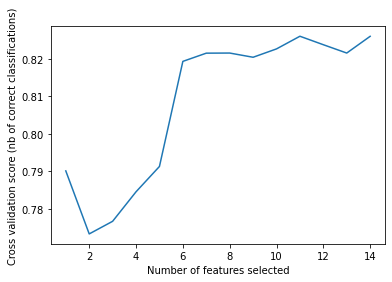

In [54]:
#
%matplotlib inline
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [33]:
sorted ( zip(rfe.ranking_,new_features))

[(1, 'Age'),
 (1, 'FamilySize'),
 (1, 'Fare'),
 (1, 'Has_Cabin'),
 (1, 'Name_length'),
 (1, 'Pclass'),
 (1, 'Random'),
 (1, 'Sex'),
 (1, 'Title'),
 (1, 'parenthese'),
 (2, 'Embarked'),
 (3, 'guill'),
 (4, 'IsAlone'),
 (5, 'Ticket')]

In [ ]:
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin', 'Embarked', 'Titre', 'parenthese', 'guill']

df_Y = df.Survived.values

param_dc = { 'max_depth' : range(1,15),
            'min_samples_leaf' : range(1,11) }

kf = StratifiedKFold( df_Y , 5)


bestscore=0

stop=False
keep = []
while( not stop ):
    stop=True
    bestFeature = None
    for feature in cols:
        if feature in keep:
            continue
        df_X = df[keep+[feature] ]      

        clf = DecisionTreeClassifier()
        gs = GridSearchCV(clf, param_dc, cv=kf)

        gs.fit( df_X, df_Y )

        score = gs.best_score_

        if score > bestscore:
            bestscore   = score
            bestFeature = feature
            stop=False
            
    if (not stop):
        keep.append(bestFeature)

    print (bestFeature, bestscore) 

In [266]:
#https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html
from sklearn.decomposition import PCA
X = train_df[new_features]

pca = PCA(n_components=6)
pca.fit(X)
X_data = pca.transform(X)
X_test = pca.transform(X)

In [267]:
pca.explained_variance_

array([86.90861567,  2.96954864,  1.59850402,  0.96571359,  0.7838656 ,
        0.59265682])

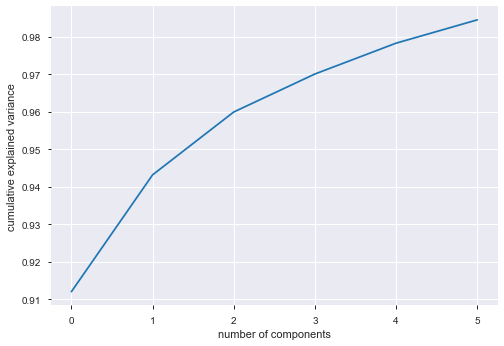

In [268]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [219]:
#Mean strategy
preds = (results_df_test.mean(axis=1) >=0.5).astype(int)

my_final_sub = pd.read_csv('.\\titanic\\test.csv')[['PassengerId']]
my_final_sub['Survived'] = preds

my_final_sub.to_csv('submission_cor_26.csv', index=False)
#Kaggle : 0.77033, 0.77511

In [271]:
#https://www.datacamp.com/community/tutorials/introduction-factor-analysis
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity,calculate_kmo
from factor_analyzer import FactorAnalyzer

#X = train_df[['Fare','SibSp','Parch','Sex']]
#sub_test = test_df[['Fare', 'SibSp','Parch','Sex']]
#y = train_df['Survived']

# Bartlett’s Test of Sphericity compares an observed correlation matrix to 
# the identity matrix. Essentially it checks to see if there is a certain 
# redundancy between the variables that we can summarize with a few number of factors. 
# https://www.statology.org/a-guide-to-bartletts-test-of-sphericity/
# https://easystats.github.io/parameters/reference/check_sphericity.html

chi_square_value,p_value = calculate_bartlett_sphericity(X)
print("Bartlet Test(p_value sould be near from 0): ",chi_square_value, p_value)

kmo_all,kmo_model=calculate_kmo(X)
print("KMO Test (should be > 0.6):", kmo_model)

Bartlet Test(p_value sould be near from 0):  nan nan
KMO Test (should be > 0.6): 0.525680366150977


In [272]:
X

,Pclass,Sex,Age,Ticket,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,...,Title,A,B,C,D,E,F,G,T,X
0,3,1,1,0,0,0,23,0,2,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,2,0,3,1,51,1,2,0,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,1,0,1,0,22,0,1,1,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,2,1,3,0,44,1,2,0,...,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1,2,1,1,0,24,0,1,1,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,1,1,1,0,21,0,1,1,...,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
887,1,0,1,1,2,0,28,1,1,1,...,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,3,0,1,0,2,0,40,0,4,0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
889,1,1,1,1,2,1,21,1,1,1,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
